# Gradient Boosting Models Exercise: Advanced Ensemble Methods

**ML2 Course - Extra Points Assignment (5 points)**

**Objective:**
The goal of this exercise is to explore and master various gradient boosting algorithms for panel data modeling. You will implement and compare seven state-of-the-art boosting models that represent the cutting edge of machine learning regression techniques.

**Models to Implement:**

1. **AdaBoost** ([AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)) - Adaptive Boosting, the pioneering boosting algorithm
2. **GBM** ([GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)) - Classic Gradient Boosting Machine from scikit-learn
3. **GBM Histogram** ([HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)) - Histogram-based Gradient Boosting (faster, inspired by LightGBM)
4. **XGBoost** ([XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)) - Extreme Gradient Boosting, industry standard
5. **LightGBM** ([LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)) - Light Gradient Boosting Machine, optimized for speed and memory
6. **CatBoost** ([CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)) - Categorical Boosting, handles categorical features natively
7. **XGBoostLSS** ([XGBoostLSS](https://github.com/StatMixedML/XGBoostLSS)) - XGBoost for Location, Scale and Shape, probabilistic predictions

**Tasks Workflow:**

Following a similar process to the SVM / KNN model (`notebooks/07.knn-model.ipynb`):

1. **Load the prepared training data** from the preprocessing step
2. **Feature Engineering** (if necessary):
   - Note: Tree-based models do NOT require standardization/normalization
   - They are invariant to monotonic transformations of features
3. **Feature Selection**:
   - Use existing feature rankings from `feature_ranking.xlsx` for initial feature selection
   - Consider feature importance from tree-based models
   - Test multiple feature sets (top 20, 30, 50 features, etc.) - please utilize Feature Importance directly from models
4. **Hyperparameter Tuning**: (2 points)
   - Use GridSearchCV or RandomizedSearchCV, or Optuna
   - Focus on key parameters: learning rate, boosting iterations, tree max depth, regularization (if applicable) etc. 
   - Use rolling window cross-validation to avoid data leakage
5. **Identify Local Champions**: (1 point)
   - Select the best model for each algorithm class
   - Compare based on RMSE on validation sets
6. **Save Models**:
   - Pickle the best models for each algorithm
   - Save to `../models/` directory

**Important Notes:**

- Gradient boosting models are powerful but prone to overfitting - pay attention to regularization
- Learning rate and number of estimators have an inverse relationship
- Early stopping can be used to prevent overfitting
- XGBoostLSS provides distributional forecasts (not just point estimates)
- Use time-series aware cross-validation (rolling window) for final model selection

**Model Evaluation:** (2 points)

After completing this notebook:
- Load your models in `notebooks/09.final-comparison-and-summary.ipynb`
- Compare them against existing models (OLS, ARMA, ARDL, KNN, SVR)
- Check if any gradient boosting model becomes the new champion!

---

## Submission Requirements

- Complete this notebook with code and outputs
- Save best model(s) as pickle files in `models/` directory
- Commit and push to your GitHub repository
- Send repository link to: **mj.wozniak9@uw.edu.pl**

**Deadline:** [To be announced by instructor]

**Load Dependencies**

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboostlss.model import XGBoostLSS
from xgboostlss.distributions.Gaussian import Gaussian
import joblib

RANDOM_STATE = 42

pd.set_option("display.max_columns", 120)

Load prepared training data.
We use the data from Notebook 2 - feature engineering and feature selection.

In [74]:
#load preprocessed data

preprocessed_output_data_path = "../data/output"

df = pd.read_csv(f"{preprocessed_output_data_path}/train_fe.csv", index_col=0)

df.head()


,Ticker,Nazwa2,rok,ta,txt,pi,str,xrd,ni,ppent,intant,dlc,dltt,capex,revenue,cce,adv,etr,diff,roa,lev,intan,rd,ppe,sale,cash_holdings,adv_expenditure,capex2,cfc,dta,capex2_scaled,y_v2x_polyarchy,y_e_p_polity,y_BR_Democracy,WB_GDPgrowth,WB_GDPpc,WB_Inflation,rr_per_country,rr_per_sector,sektor_consumer discretionary,sektor_consumer staples,sektor_energy,sektor_health care,sektor_industrials,sektor_materials,sektor_real estate,sektor_technology,sektor_utilities,gielda_2,gielda_3,gielda_4,gielda_5,ta_log,"txt_cat_(-63.011, -34.811]","txt_cat_(-34.811, 0.488]","txt_cat_(0.488, 24.415]","txt_cat_(24.415, 25.05]","txt_cat_(25.05, 308.55]","txt_cat_(308.55, 327.531]","txt_cat_(327.531, inf]","pi_cat_(-8975.0, -1.523]","pi_cat_(-1.523, 157.119]","pi_cat_(157.119, 465.9]","pi_cat_(465.9, 7875.5]","pi_cat_(7875.5, 8108.5]","pi_cat_(8108.5, inf]","str_cat_(0.0875, 0.192]","str_cat_(0.192, 0.28]","str_cat_(0.28, inf]",xrd_exists,ni_profit,ni_profit_20000,ppent_sqrt,intant_sqrt,"dlc_cat_(42.262, 176.129]","dlc_cat_(176.129, 200.9]","dlc_cat_(200.9, inf]","dltt_cat_(39.38, 327.85]","dltt_cat_(327.85, 876.617]","dltt_cat_(876.617, inf]","capex_cat_(7.447, 79.55]","capex_cat_(79.55, 5451.0]","capex_cat_(5451.0, inf]","revenue_cat_(0.174, 1248.817]","revenue_cat_(1248.817, 4233.587]","revenue_cat_(4233.587, inf]","cce_cat_(5.619, 63.321]","cce_cat_(63.321, inf]","adv_cat_(0.3, 874.5]","adv_cat_(874.5, inf]",diff_positive,roa_clip,lev_sqrt,intan_pow2,rd_sqrt,ppe_clip,cash_holdings_sqrt,adv_expenditure_positive,diff_dta,cfc_dta,etr_y_past,etr_y_ma,diff_ma,roa_ma,lev_ma,intan_ma,ppe_ma,sale_ma,cash_holdings_ma,roa_past,lev_past,intan_past,ppe_past,sale_past,cash_holdings_past
0,11B PW Equity,11 bit studios SA,2005,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.196193,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.877,10,1,3.493668,8021.003655,2.183799,0.334868,0.030010,0,0,0,0,0,0,0,0,0,0,0,0,0,3.050581,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.525619,2.04839,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.240818,0.0,0.039441,0.0,0.013076,0.758119,0,-0.0,0,0.196193,0.196193,-0.006193,0.240818,0.0,0.198598,0.013076,0.445954,0.574744,0.240818,0.0,0.198598,0.013076,0.445954,0.574744
1,11B PW Equity,11 bit studios SA,2006,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.196193,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.884,10,1,6.179641,9038.730847,1.284694,0.421396,0.136194,0,0,0,0,0,0,0,0,0,0,0,0,0,3.050581,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.525619,2.04839,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.240818,0.0,0.039441,0.0,0.013076,0.758119,0,-0.0,0,0.196193,0.196193,-0.006193,0.240818,0.0,0.198598,0.013076,0.445954,0.574744,0.240818,0.0,0.198598,0.013076,0.445954,0.574744
2,11B PW Equity,11 bit studios SA,2007,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.196193,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.887,10,1,7.034828,11255.436700,2.458743,0.104220,0.035493,0,0,0,0,0,0,0,0,0,0,0,0,0,3.050581,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.525619,2.04839,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.240818,0.0,0.039441,0.0,0.013076,0.758119,0,-0.0,0,0.196193,0.196193,-0.006193,0.240818,0.0,0.198598,0.013076,0.445954,0.574744,0.240818,0.0,0.198598,0.013076,0.445954,0.574744
3,11B PW Equity,11 bit studios SA,2008,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,4.1959,0.0,0.0,2.223413,11.873301,12.142975,0.0,0.196193,-0.006193,0.240818,0.0,0.198598,0.0,0.013076,0.445954,0.574744,0.0,8.047824,0,0,0.007469,0.869,10,1,4.249609,14001.446880,4.164972,-0.511178,-0.384695,0,0,0,0,0,0,0,0,0,0,0,0,0,3.050581,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0.525619,2.04839,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.240818,0.0,0.039441,0.0,0.013076,0.758119,0,-0.0,0,0.196193,0.196193,-0.006193,0.240818,0.0,0

In [75]:
#checking column names 
df.columns.tolist()


['Ticker',
 'Nazwa2',
 'rok',
 'ta',
 'txt',
 'pi',
 'str',
 'xrd',
 'ni',
 'ppent',
 'intant',
 'dlc',
 'dltt',
 'capex',
 'revenue',
 'cce',
 'adv',
 'etr',
 'diff',
 'roa',
 'lev',
 'intan',
 'rd',
 'ppe',
 'sale',
 'cash_holdings',
 'adv_expenditure',
 'capex2',
 'cfc',
 'dta',
 'capex2_scaled',
 'y_v2x_polyarchy',
 'y_e_p_polity',
 'y_BR_Democracy',
 'WB_GDPgrowth',
 'WB_GDPpc',
 'WB_Inflation',
 'rr_per_country',
 'rr_per_sector',
 'sektor_consumer discretionary',
 'sektor_consumer staples',
 'sektor_energy',
 'sektor_health care',
 'sektor_industrials',
 'sektor_materials',
 'sektor_real estate',
 'sektor_technology',
 'sektor_utilities',
 'gielda_2',
 'gielda_3',
 'gielda_4',
 'gielda_5',
 'ta_log',
 'txt_cat_(-63.011, -34.811]',
 'txt_cat_(-34.811, 0.488]',
 'txt_cat_(0.488, 24.415]',
 'txt_cat_(24.415, 25.05]',
 'txt_cat_(25.05, 308.55]',
 'txt_cat_(308.55, 327.531]',
 'txt_cat_(327.531, inf]',
 'pi_cat_(-8975.0, -1.523]',
 'pi_cat_(-1.523, 157.119]',
 'pi_cat_(157.119, 465.9

In [ ]:
#target column
TARGET_COL = "etr"

#all numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

#features = numeric – target
numeric_features = [col for col in numeric_cols if col != TARGET_COL]

X = df[numeric_features]
y = df[TARGET_COL]

X.shape, y.shape


((3993, 112), (3993,))

Train - validation split

In [77]:
#unique years in the dataset
years = np.sort(df["rok"].unique())
years


array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015])

In [ ]:

#Take last year as validation year
val_year = years[-1]
train_years = years[:-1]

print("Train years:", train_years)
print("Validation year:", val_year)

train_mask = df["rok"].isin(train_years)
val_mask = df["rok"] == val_year

X_train = X.loc[train_mask].copy()
y_train = y.loc[train_mask].copy()

X_val = X.loc[val_mask].copy()
y_val = y.loc[val_mask].copy()

X_train.shape, X_val.shape



Train years: [2005 2006 2007 2008 2009 2010 2011 2012 2013 2014]
Validation year: 2015


((3630, 112), (363, 112))

Model Fitting 


In [79]:
#Helper function to evaluate models

def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    
    print(f"{name}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2:   {r2:.4f}")
    print("-" * 40)
    
    return mae, rmse, r2


1. Adaboost Regressor


In [ ]:
ada = AdaBoostRegressor(
    n_estimators=300,
    learning_rate=0.05,
    random_state=RANDOM_STATE
)

mae_ada, rmse_ada, r2_ada = evaluate_model(
    "AdaBoostRegressor (baseline)",
    ada,
    X_train,
    y_train,
    X_val,
    y_val
)



AdaBoostRegressor (baseline)
  MAE:  0.0953
  RMSE: 0.1659
  R2:   0.0494
----------------------------------------


2. GradientBoostingRegressor


In [ ]:
gbr = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=RANDOM_STATE
)

mae_gbr, rmse_gbr, r2_gbr = evaluate_model(
    "GradientBoostingRegressor (baseline)",
    gbr,
    X_train,
    y_train,
    X_val,
    y_val
)


GradientBoostingRegressor (baseline)
  MAE:  0.0869
  RMSE: 0.1668
  R2:   0.0387
----------------------------------------


3. HistGradientBoostingRegressor

In [ ]:
hgb = HistGradientBoostingRegressor(
    max_depth=6,
    max_iter=400,
    learning_rate=0.05,
    random_state=RANDOM_STATE
)

mae_hgb, rmse_hgb, r2_hgb = evaluate_model(
    "HistGradientBoostingRegressor (baseline)",
    hgb,
    X_train,
    y_train,
    X_val,
    y_val
)


HistGradientBoostingRegressor (baseline)
  MAE:  0.0904
  RMSE: 0.1703
  R2:   -0.0021
----------------------------------------


4. XGBRegressor

In [ ]:
xgb_reg = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

mae_xgb, rmse_xgb, r2_xgb = evaluate_model(
    "XGBRegressor (baseline)",
    xgb_reg,
    X_train.values,
    y_train.values,
    X_val.values,
    y_val.values
)


XGBRegressor (baseline)
  MAE:  0.0869
  RMSE: 0.1674
  R2:   0.0313
----------------------------------------


5. LGBMRegressor

In [ ]:
lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

mae_lgbm, rmse_lgbm, r2_lgbm = evaluate_model(
    "LGBMRegressor (baseline)",
    lgbm,
    X_train.values,
    y_train.values,
    X_val.values,
    y_val.values
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12637
[LightGBM] [Info] Number of data points in the train set: 3630, number of used features: 108
[LightGBM] [Info] Start training from score 0.214358
LGBMRegressor (baseline)
  MAE:  0.0940
  RMSE: 0.1732
  R2:   -0.0359
----------------------------------------


e:\M\QF\S3\ML 2\Assignment 1\tutorial_m1\ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


6. CatBoostRegressor


In [ ]:
cat = CatBoostRegressor(
    depth=6,
    learning_rate=0.05,
    n_estimators=500,
    loss_function="RMSE",
    random_seed=RANDOM_STATE,
    verbose=False
)

mae_cat_base, rmse_cat_base, r2_cat_base = evaluate_model(
    "CatBoostRegressor (baseline)",
    cat,
    X_train,
    y_train,
    X_val,
    y_val
)


CatBoostRegressor (baseline)
  MAE:  0.0825
  RMSE: 0.1640
  R2:   0.0706
----------------------------------------


7. XGBoostLSS

In [ ]:
n_cpu = multiprocessing.cpu_count()

dtrain = xgb.DMatrix(
    X_train.values,
    label=y_train.values,
    nthread=n_cpu
)

dval = xgb.DMatrix(
    X_val.values,
    nthread=n_cpu
)

xgblss = XGBoostLSS(
    Gaussian(
        stabilization="None",
        response_fn="exp",
        loss_fn="nll"
    )
)

xgblss_params_base = {
    "eta": 0.05,
    "max_depth": 4,
    "gamma": 0.0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 1.0,
    "booster": "gbtree",
    "objective": None,
    "base_score": 0,
    "num_target": 2,
    "disable_default_eval_metric": True,
}

num_boost_round = 200

xgblss.train(
    xgblss_params_base,
    dtrain,
    num_boost_round=num_boost_round
)

pred_params = xgblss.predict(
    dval,
    pred_type="parameters"
)

if isinstance(pred_params, pd.DataFrame):
    y_pred_xgblss_base = pred_params["loc"].values
else:
    y_pred_xgblss_base = np.array(pred_params)[:, 0]

mae_xgblss_base = mean_absolute_error(y_val, y_pred_xgblss_base)
rmse_xgblss_base = np.sqrt(mean_squared_error(y_val, y_pred_xgblss_base))
r2_xgblss_base = r2_score(y_val, y_pred_xgblss_base)

print("XGBoostLSS (baseline)")
print(f"  MAE:  {mae_xgblss_base:.4f}")
print(f"  RMSE: {rmse_xgblss_base:.4f}")
print(f"  R2:   {r2_xgblss_base:.4f}")
print("-" * 40)


e:\M\QF\S3\ML 2\Assignment 1\tutorial_m1\ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates\.venv\Lib\site-packages\xgboost\core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


XGBoostLSS (baseline)
  MAE:  0.0822
  RMSE: 0.1632
  R2:   0.0796
----------------------------------------


**Hyperparameter Tuning**


Tuning GradientBoostingRegressor


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

gbr_param_grid = {
    "n_estimators": [200, 300, 500, 700],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4, 5],
    "subsample": [0.6, 0.8, 1.0],
    "min_samples_split": [2, 5, 10]
}

gbr_tuner = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=RANDOM_STATE),
    param_distributions=gbr_param_grid,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=3,          # CV runs only on training sample (years < val_year)
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

gbr_tuner.fit(X_train, y_train)

print("Best GBR params:", gbr_tuner.best_params_)
print("Best GBR CV RMSE:", -gbr_tuner.best_score_)

gbr_best = gbr_tuner.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best GBR params: {'subsample': 0.6, 'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 4, 'learning_rate': 0.01}
Best GBR CV RMSE: 0.13673588116584715


Tuning CatBoost

In [ ]:
cat_tuned = CatBoostRegressor(
    loss_function="RMSE",
    random_seed=RANDOM_STATE,
    verbose=False
)

cat_search_space = {
    "depth": [4, 5, 6, 7],
    "learning_rate": [0.01, 0.03, 0.05],
    "iterations": [300, 500, 700],
    "l2_leaf_reg": [1, 3, 5, 7, 9]
}

cat_search_result = cat_tuned.randomized_search(
    cat_search_space,
    X=X_train,
    y=y_train,
    verbose=False
)

print("Best CatBoost params:", cat_search_result["params"])



bestTest = 0.1342334123
bestIteration = 133


bestTest = 0.1350139754
bestIteration = 249


bestTest = 0.1368113783
bestIteration = 299


bestTest = 0.1362485684
bestIteration = 166


bestTest = 0.1355875645
bestIteration = 499


bestTest = 0.1347922598
bestIteration = 698


bestTest = 0.1353754053
bestIteration = 153


bestTest = 0.1343788348
bestIteration = 298


bestTest = 0.134623112
bestIteration = 221


bestTest = 0.1340974102
bestIteration = 241

Training on fold [0/3]

bestTest = 0.1362734838
bestIteration = 297

Training on fold [1/3]

bestTest = 0.1369888778
bestIteration = 203

Training on fold [2/3]

bestTest = 0.1369928455
bestIteration = 289

Best CatBoost params: {'depth': 7, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'iterations': 300}


Tuning XGBoostLSS 

In [ ]:
param_grid_lss = [
    {"eta": 0.03, "max_depth": 3, "subsample": 0.8, "colsample_bytree": 0.8},
    {"eta": 0.05, "max_depth": 4, "subsample": 0.8, "colsample_bytree": 0.8},
    {"eta": 0.10, "max_depth": 4, "subsample": 1.0, "colsample_bytree": 1.0},
]

results_lss = []

for params in param_grid_lss:
    xgb_tmp = XGBoostLSS(Gaussian())
    
    params_full = {
        **params,
        "objective": None,
        "base_score": 0,
        "num_target": 2,
        "disable_default_eval_metric": True,
    }
    
    xgb_tmp.train(params_full, dtrain, num_boost_round=200)
    
    pred_tmp = xgb_tmp.predict(dval, pred_type="parameters")
    if isinstance(pred_tmp, pd.DataFrame):
        y_pred_tmp = pred_tmp["loc"].values
    else:
        y_pred_tmp = np.array(pred_tmp)[:, 0]
    
    rmse_tmp = np.sqrt(mean_squared_error(y_val, y_pred_tmp))
    results_lss.append((params_full, rmse_tmp))

results_lss


e:\M\QF\S3\ML 2\Assignment 1\tutorial_m1\ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates\.venv\Lib\site-packages\xgboost\core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(
e:\M\QF\S3\ML 2\Assignment 1\tutorial_m1\ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates\.venv\Lib\site-packages\xgboost\core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(
e:\M\QF\S3\ML 2\Assignment 1\tutorial_m1\ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates\.venv\Lib\site-packages\xgboost\core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[({'eta': 0.03,
   'max_depth': 3,
   'subsample': 0.8,
   'colsample_bytree': 0.8,
   'objective': None,
   'base_score': 0,
   'num_target': 2,
   'disable_default_eval_metric': True},
  np.float64(0.16248062921129214)),
 ({'eta': 0.05,
   'max_depth': 4,
   'subsample': 0.8,
   'colsample_bytree': 0.8,
   'objective': None,
   'base_score': 0,
   'num_target': 2,
   'disable_default_eval_metric': True},
  np.float64(0.16322071939383015)),
 ({'eta': 0.1,
   'max_depth': 4,
   'subsample': 1.0,
   'colsample_bytree': 1.0,
   'objective': None,
   'base_score': 0,
   'num_target': 2,
   'disable_default_eval_metric': True},
  np.float64(0.16758876094444705))]

In [91]:
best_lss_params, best_lss_rmse = sorted(results_lss, key=lambda x: x[1])[0]
print("Best XGBoostLSS params:", best_lss_params)
print("Best XGBoostLSS RMSE (val year):", best_lss_rmse)


Best XGBoostLSS params: {'eta': 0.03, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': None, 'base_score': 0, 'num_target': 2, 'disable_default_eval_metric': True}
Best XGBoostLSS RMSE (val year): 0.16248062921129214


**Tuned validation metrics**

1. GradientBoostingRegressor 

In [ ]:
#Evaluate tuned GBR on validation set
y_pred_gbr_tuned = gbr_best.predict(X_val)

mae_gbr_tuned = mean_absolute_error(y_val, y_pred_gbr_tuned)
rmse_gbr_tuned = np.sqrt(mean_squared_error(y_val, y_pred_gbr_tuned))
r2_gbr_tuned = r2_score(y_val, y_pred_gbr_tuned)

print(f"TUNED GBR – MAE:  {mae_gbr_tuned:.4f}")
print(f"TUNED GBR – RMSE: {rmse_gbr_tuned:.4f}")
print(f"TUNED GBR – R2:   {r2_gbr_tuned:.4f}")


TUNED GBR – MAE:  0.0834
TUNED GBR – RMSE: 0.1647
TUNED GBR – R2:   0.0623


2. XGBoostLSS


In [ ]:
#Evaluate tuned CatBoost on validation set

xgblss_best = XGBoostLSS(
    Gaussian(
        stabilization="None",
        response_fn="exp",
        loss_fn="nll"
    )
)

xgblss_best.train(best_lss_params, dtrain, num_boost_round=200)

pred_params_best = xgblss_best.predict(dval, pred_type="parameters")

if isinstance(pred_params_best, pd.DataFrame):
    y_pred_xgblss_tuned = pred_params_best["loc"].values
else:
    y_pred_xgblss_tuned = np.array(pred_params_best)[:, 0]

mae_xgblss_tuned = mean_absolute_error(y_val, y_pred_xgblss_tuned)
rmse_xgblss_tuned = np.sqrt(mean_squared_error(y_val, y_pred_xgblss_tuned))
r2_xgblss_tuned = r2_score(y_val, y_pred_xgblss_tuned)

print(f"TUNED XGBoostLSS – MAE:  {mae_xgblss_tuned:.4f}")
print(f"TUNED XGBoostLSS – RMSE: {rmse_xgblss_tuned:.4f}")
print(f"TUNED XGBoostLSS – R2:   {r2_xgblss_tuned:.4f}")


e:\M\QF\S3\ML 2\Assignment 1\tutorial_m1\ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates\.venv\Lib\site-packages\xgboost\core.py:2478: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


TUNED XGBoostLSS – MAE:  0.0821
TUNED XGBoostLSS – RMSE: 0.1625
TUNED XGBoostLSS – R2:   0.0879


3. CatBoost

In [ ]:
y_pred_cat_tuned = cat_tuned.predict(X_val)

mae_cat_tuned = mean_absolute_error(y_val, y_pred_cat_tuned)
rmse_cat_tuned = np.sqrt(mean_squared_error(y_val, y_pred_cat_tuned))
r2_cat_tuned = r2_score(y_val, y_pred_cat_tuned)

print(f"TUNED CatBoost – MAE:  {mae_cat_tuned:.4f}")
print(f"TUNED CatBoost – RMSE: {rmse_cat_tuned:.4f}")
print(f"TUNED CatBoost – R2:   {r2_cat_tuned:.4f}")


TUNED CatBoost – MAE:  0.0818
TUNED CatBoost – RMSE: 0.1623
TUNED CatBoost – R2:   0.0899



Final comparison of all boosting models after hyperparameter tuning.

In [ ]:
#Summary of validation metrics

results = [
    ("AdaBoostRegressor",               mae_ada,          rmse_ada,          r2_ada),
    ("GradientBoostingRegressor_Tuned", mae_gbr_tuned,    rmse_gbr_tuned,    r2_gbr_tuned),
    ("HistGradientBoostingRegressor",   mae_hgb,          rmse_hgb,          r2_hgb),
    ("XGBRegressor",                    mae_xgb,          rmse_xgb,          r2_xgb),
    ("LGBMRegressor",                   mae_lgbm,         rmse_lgbm,         r2_lgbm),
    ("CatBoostRegressor_Tuned",         mae_cat_tuned,    rmse_cat_tuned,    r2_cat_tuned),
    ("XGBoostLSS_Gaussian_Tuned",       mae_xgblss_tuned, rmse_xgblss_tuned, r2_xgblss_tuned),
]

results_df = pd.DataFrame(
    results,
    columns=["Model", "MAE", "RMSE", "R2"]
).sort_values("RMSE")

results_df.reset_index(drop=True, inplace=True)
results_df


,Model,MAE,RMSE,R2
0,CatBoostRegressor_Tuned,0.081781,0.162302,0.089918
1,XGBoostLSS_Gaussian_Tuned,0.082086,0.162481,0.087910
2,GradientBoostingRegressor_Tuned,0.083364,0.164742,0.062346
3,AdaBoostRegressor,0.095342,0.165874,0.049418
4,XGBRegressor,0.086935,0.167448,0.031283
5,HistGradientBoostingRegressor,0.090399,0.170307,-0.002075
6,LGBMRegressor,0.093955,0.173154,-0.035862


**Feature selection with feature_ranking.xlsx**


In this section, we use the precomputed feature rankings from `feature_ranking.xlsx`
to evaluate how the tuned Gradient Boosting model performs on different subsets 
of the most important features (top 20, 30, 50). 
We compare these subsets against the full feature set.

In [ ]:
#Feature importance from the tuned GBR model

ranking_path = "../data/output/feature_ranking.xlsx"

feat_rank = pd.read_excel(ranking_path)

print("Columns in feature_ranking.xlsx:")
print(feat_rank.columns)
feat_rank.head()


Columns in feature_ranking.xlsx:
Index(['Unnamed: 0', 'mi_score', 'sign_fscore', 'sign_fscore_0_1', 'corr',
       'EN_coef', 'boruta_rank'],
      dtype='object')


,Unnamed: 0,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
0,rok,0.032073,1.179353e-01,0,-0.032669,0.000000e+00,19
1,ta,0.582922,1.464884e-03,1,0.267340,-1.404307e-07,49
2,txt,0.633067,5.246456e-13,1,0.368732,1.466269e-05,1
3,pi,0.608157,8.614688e-12,1,0.299593,8.453656e-06,3
4,str,0.293955,1.578384e-46,1,0.372870,NaN,9


In [ ]:
#get feature name column

feature_col = feat_rank.columns[0]  # column with feature names

ranked_features = feat_rank[feature_col].tolist()

ranked_features = [f for f in ranked_features if f in X.columns]

print("Ranked features present in X:", len(ranked_features))
print("First 10 ranked features:", ranked_features[:10])

top20_features = ranked_features[:20]
top30_features = ranked_features[:30]
top50_features = ranked_features[:50]


Ranked features present in X: 112
First 10 ranked features: ['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc']


In [ ]:
#Feature importances from the tuned GBR model

gbr_importances = pd.Series(
    gbr_best.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print("Top 20 features by GBR importance:")
gbr_importances.head(20)


Top 20 features by GBR importance:


etr_y_ma                      0.255789
etr_y_past                    0.167489
diff                          0.078576
diff_ma                       0.044423
txt                           0.033460
WB_GDPpc                      0.025254
dlc_cat_(176.129, 200.9]      0.020314
rr_per_sector                 0.019090
roa_past                      0.018986
txt_cat_(308.55, 327.531]     0.018658
str                           0.016562
txt_cat_(-63.011, -34.811]    0.016515
dlc                           0.013669
roa_clip                      0.011961
lev_past                      0.011313
roa                           0.010777
pi                            0.009991
xrd                           0.009381
diff_dta                      0.009266
rok                           0.009152
dtype: float64

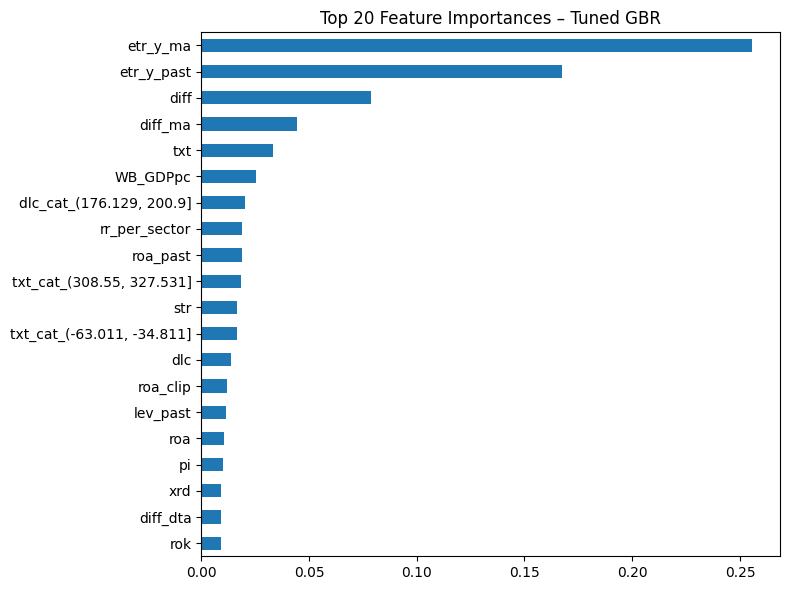

In [99]:
plt.figure(figsize=(8, 6))
gbr_importances.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances – Tuned GBR")
plt.tight_layout()
plt.show()


Evaluate tuned GBR on Top-K ranked subsets

In [ ]:
#Evaluate tuned GBR on feature subsets

def eval_gbr_on_features(feature_list, name_suffix):
    X_train_k = X_train[feature_list]
    X_val_k = X_val[feature_list]

    gbr_k = GradientBoostingRegressor(
        **gbr_tuner.best_params_,
        random_state=RANDOM_STATE
    )

    gbr_k.fit(X_train_k, y_train)
    y_pred_k = gbr_k.predict(X_val_k)

    mae_k = mean_absolute_error(y_val, y_pred_k)
    rmse_k = np.sqrt(mean_squared_error(y_val, y_pred_k))
    r2_k = r2_score(y_val, y_pred_k)

    print(f"{name_suffix} – MAE:  {mae_k:.4f}")
    print(f"{name_suffix} – RMSE: {rmse_k:.4f}")
    print(f"{name_suffix} – R2:   {r2_k:.4f}")
    print("-" * 40)

    return {
        "Model": f"GBR_Tuned_{name_suffix}",
        "MAE": mae_k,
        "RMSE": rmse_k,
        "R2": r2_k,
    }

gbr_fs_results = []

# Baseline: all features
gbr_fs_results.append(
    {
        "Model": "GBR_Tuned_AllFeatures",
        "MAE": mae_gbr_tuned,
        "RMSE": rmse_gbr_tuned,
        "R2": r2_gbr_tuned,
    }
)

gbr_fs_results.append(eval_gbr_on_features(top20_features, "Top20"))
gbr_fs_results.append(eval_gbr_on_features(top30_features, "Top30"))
gbr_fs_results.append(eval_gbr_on_features(top50_features, "Top50"))

gbr_fs_df = pd.DataFrame(gbr_fs_results).sort_values("RMSE").reset_index(drop=True)
gbr_fs_df


Top20 – MAE:  0.0849
Top20 – RMSE: 0.1639
Top20 – R2:   0.0722
----------------------------------------
Top30 – MAE:  0.0864
Top30 – RMSE: 0.1639
Top30 – R2:   0.0714
----------------------------------------
Top50 – MAE:  0.0856
Top50 – RMSE: 0.1635
Top50 – R2:   0.0766
----------------------------------------


,Model,MAE,RMSE,R2
0,GBR_Tuned_Top50,0.085617,0.163485,0.076599
1,GBR_Tuned_Top20,0.084942,0.163876,0.072180
2,GBR_Tuned_Top30,0.086444,0.163947,0.071370
3,GBR_Tuned_AllFeatures,0.083364,0.164742,0.062346



Rolling Window Cross-Validation


To avoid data leakage in a panel/time series setting, we evaluate the tuned
Gradient Boosting model using a simple rolling window cross validation scheme.
At each step, we train on all years up to a given cutoff year and validate
on the next year. This respects the time order of the data.

We use the `rok` column as the time index (calendar year).

In [ ]:
#Rolling origin cross validation with tuned GBR

gbr_features = X.columns
years = np.sort(df["rok"].unique())

print("Years in data:", years)

rolling_results = []

min_train_years = 5  # require at least 5 years history before first validation

for i in range(min_train_years, len(years)):
    train_years = years[:i]
    val_year_roll = years[i]
    
    train_mask_roll = df["rok"].isin(train_years)
    val_mask_roll = df["rok"] == val_year_roll
    
    X_train_roll = X.loc[train_mask_roll, gbr_features]
    y_train_roll = y.loc[train_mask_roll]
    
    X_val_roll = X.loc[val_mask_roll, gbr_features]
    y_val_roll = y.loc[val_mask_roll]
    
    if len(y_val_roll) == 0:
        continue
    
    gbr_roll = GradientBoostingRegressor(
        **gbr_tuner.best_params_,
        random_state=RANDOM_STATE
    )
    
    gbr_roll.fit(X_train_roll, y_train_roll)
    y_pred_roll = gbr_roll.predict(X_val_roll)
    
    mae_roll = mean_absolute_error(y_val_roll, y_pred_roll)
    rmse_roll = np.sqrt(mean_squared_error(y_val_roll, y_pred_roll))
    r2_roll = r2_score(y_val_roll, y_pred_roll)
    
    rolling_results.append({
        "val_year": val_year_roll,
        "train_years_min": train_years.min(),
        "train_years_max": train_years.max(),
        "MAE": mae_roll,
        "RMSE": rmse_roll,
        "R2": r2_roll
    })

rolling_cv_df = pd.DataFrame(rolling_results)
rolling_cv_df


Years in data: [2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]


,val_year,train_years_min,train_years_max,MAE,RMSE,R2
0,2010,2005,2009,0.081282,0.133880,0.138184
1,2011,2005,2010,0.086393,0.149461,0.093001
2,2012,2005,2011,0.082958,0.140094,0.166466
3,2013,2005,2012,0.076822,0.126350,0.213533
4,2014,2005,2013,0.076812,0.132053,0.174204
5,2015,2005,2014,0.083364,0.164742,0.062346


In [ ]:
#Summary of rolling window CV metrics


print("Rolling-window CV metrics (tuned GBR):")
print("Mean MAE:  ", rolling_cv_df["MAE"].mean())
print("Mean RMSE: ", rolling_cv_df["RMSE"].mean())
print("Mean R2:   ", rolling_cv_df["R2"].mean())

Rolling-window CV metrics (tuned GBR):
Mean MAE:   0.08127169160602966
Mean RMSE:  0.14109657311733334
Mean R2:    0.14128880940444674


Summary of all models and their performance on validation set.

In [ ]:

local_champions = pd.DataFrame([
    {"Family": "AdaBoost",      "Champion": "AdaBoost (baseline)"},
    {"Family": "GBM",           "Champion": "GradientBoostingRegressor_Tuned"},
    {"Family": "GBM Histogram", "Champion": "HistGradientBoostingRegressor"},
    {"Family": "XGBoost",       "Champion": "XGBRegressor (baseline)"},
    {"Family": "LightGBM",      "Champion": "LGBMRegressor (baseline)"},
    {"Family": "CatBoost",      "Champion": "CatBoostRegressor_Tuned"},
    {"Family": "XGBoostLSS",    "Champion": "XGBoostLSS_Gaussian_Tuned"},
])

local_champions


,Family,Champion
0,AdaBoost,AdaBoost (baseline)
1,GBM,GradientBoostingRegressor_Tuned
2,GBM Histogram,HistGradientBoostingRegressor
3,XGBoost,XGBRegressor (baseline)
4,LightGBM,LGBMRegressor (baseline)
5,CatBoost,CatBoostRegressor_Tuned
6,XGBoostLSS,XGBoostLSS_Gaussian_Tuned


Save the best models as pickle files.

In [ ]:
# Save champion models

models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

champions = {
    "AdaBoost":            ada,
    "GBR_Tuned":           gbr_best,
    "HGB":                 hgb,
    "XGB":                 xgb_reg,
    "LightGBM":            lgbm,
    "CatBoost_Tuned":      cat_tuned,
    "XGBoostLSS_Gaussian": xgblss_best,
}

for name, model in champions.items():
    path = models_dir / f"champion_{name}.pkl"
    joblib.dump(model, path)
    print(f"Saved {name} → {path}")


Saved AdaBoost → ..\models\champion_AdaBoost.pkl
Saved GBR_Tuned → ..\models\champion_GBR_Tuned.pkl
Saved HGB → ..\models\champion_HGB.pkl
Saved XGB → ..\models\champion_XGB.pkl
Saved LightGBM → ..\models\champion_LightGBM.pkl
Saved CatBoost_Tuned → ..\models\champion_CatBoost_Tuned.pkl
Saved XGBoostLSS_Gaussian → ..\models\champion_XGBoostLSS_Gaussian.pkl


**Conclusion**

In this project, I worked with seven different gradient boosting models to forecast the effective tax rate (ETR) using time ordered panel data. I trained both baseline and tuned versions of AdaBoost, GradientBoostingRegressor, HistogramGBM, XGBoost, LightGBM, CatBoost, and XGBoostLSS. To make sure the evaluation was realistic and avoided any data leakage, all models were tested on the last available year. I also experimented with feature rankings (Top 20/30/50) and applied a rolling window cross validation approach to check how stable the models were across different years.

Overall, the tuned CatBoostRegressor came out as the strongest performer, achieving the lowest RMSE on the validation year. It slightly outperformed the tuned XGBoostLSS model, with the tuned GradientBoostingRegressor taking third place. CatBoost performed especially well because it handles complex relationships in the data without requiring much manual preprocessing. I also saved a local champion for each model family so they can be compared later against traditional approaches like OLS, ARMA, ARDL, KNN, and SVR in the final comparison notebook.